In [14]:
# importing packages

import numpy as np
import scipy.stats as stats
from numpy.linalg import inv
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
# Simulate Data
HERITABILITY = 0.85
p = 0.05
INDIVIDUALS = 300
MARKERS = 1000


# x in {0,1,2}
X = np.random.randint(0,3, size=(INDIVIDUALS,MARKERS))

# each marker has a p chance of have a normally distributed effect
# with variance 1
effect = np.random.normal(0, 1, size=(MARKERS))
for i in range(len(effect)):
    if np.random.random() > p:
        effect[i] = 0
noise = np.random.normal(0, 1 - HERITABILITY, size=(INDIVIDUALS))

# generate phenotypes
y = ((X).dot(effect) + noise)
y = (y-np.mean(y))/np.std(y)


df = {'y' : y}
df.update({f'x{i}': X.T[i] for i in range(MARKERS)})
df = pd.DataFrame(df)
df.to_csv('GWAS_data.csv')

In [32]:
def compute_beta_value(X_i, y):
    # solves linear regression 
   
    X_i =np.array([list(np.ones(len(X_i))),  list(X_i)]).T
    return (np.matmul(np.linalg.inv(np.matmul(X_i.T, X_i)), (np.matmul(X_i.T, y))))[1]

def compute_y_hat(X_i, beta):
    return np.array([x * beta  for x in X_i])

def compute_se(X_i, y, beta):
    n = len(y)
    y_hat = compute_y_hat(X_i, beta)
    x_bar = sum(X_i)/len(X_i)
  
    return (  np.sqrt(sum((y[i]- y_hat[i])**2 for i in range(n))/(n-2))
            / np.sqrt(sum((X_i[j] - x_bar)**2 for j in range(len(X_i)))))

def compute_t(X_i,y):
    beta = compute_beta_value(X_i,y)
    se = compute_se(X_i, y, beta)
    return beta/se

# solve linear equation for each beta
t_stats = np.array([compute_t(x_i, y) for x_i in X.T])
p_vals = 2*(np.array([1-stats.t.cdf(abs(t), len(y)-2) for t in t_stats]))

[0.38298239 0.18765867 0.55903315 0.69942091 0.60538897 0.77301556
 0.50491947]


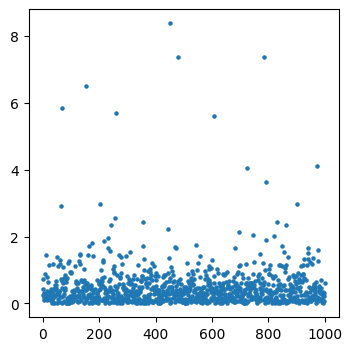

In [35]:
# Figure of betas and true phenotypes
plt.figure(figsize=(4, 4))
plt.scatter(np.arange(MARKERS), -np.log10(p_vals), s=5)


print(p_vals[:7])

env: R_HOME=/Library/Frameworks/R.framework/Resources
env: R_LIBS_USER=/Users/paddygibbs/Library/R/arm64/4.2/library
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


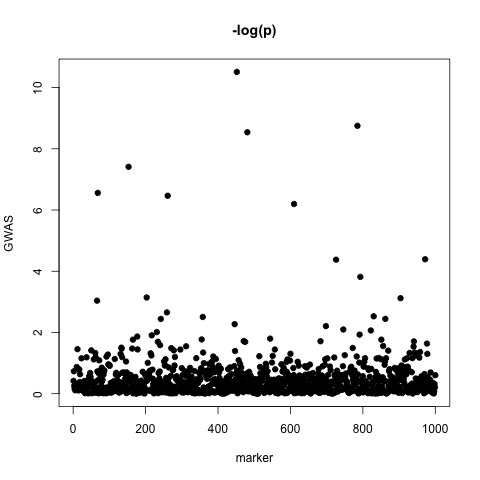

In [37]:
%%R

# Initialize a list to store model summaries
p_values <- list()

# Loop through each predictor in columns 2 to 1002
for (i in 3:1002) {
    # Extract the predictor name e.g. x1, or x2
    predictor_name <- names(df)[i]
    formula <- as.formula(paste("y ~", predictor_name))
    model <- lm(formula, data=df)

    # store p value from t statistic 
    p_values[[predictor_name]] <- summary(model)$coefficients[, "Pr(>|t|)"][predictor_name]
}
# log transform p values
log_p_values <- sapply(p_values, function(p) -log10(p))

x <- 1:1000

# Creating the scatter plot
plot(x, log_p_values, pch = 19, main = "-log(p)", xlab = "marker", ylab = "GWAS")

